## Probability Calibration

The goal of this notebook is to investigate the accuracy of the model's reported probabilities. Methods of calibrating models will also be explored.

One method to visualise the accuracy of probabilities is to use a calibration curve. A calibration curve plots observed frequency against the predicited probability. If a model's prediction matches reality perfectly, the curve should be a perfect y = x line.

To quantify the model calibration, ECE and Brier score is measured.

In [2]:
# importing dataset
import sys, os

# Project root: /Users/jaydenshi/Documents/Code/Projects/atp-forecaster
PROJECT_ROOT = os.path.abspath("../..")

# Add src/ to sys.path so `atp_forecaster` is importable
SRC_ROOT = os.path.join(PROJECT_ROOT, "src")
if SRC_ROOT not in sys.path:
    sys.path.insert(0, SRC_ROOT)

from atp_forecaster.data import load_training_data_xgb_v1

from sklearn.model_selection import train_test_split

X, y = load_training_data_xgb_v1()

test_size = 0.4
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

def produce_calibration_curve(model, x_train, x_test, y_train, y_test, n_bins=50):
    model.fit(x_train, y_train)

    # Predicted probabilities for positive class
    y_proba = model.predict_proba(x_test)[:, 1]

    brier = brier_score_loss(y_test, y_proba)

    # ECE
    # Bin predictions into n_bins uniformly over [0, 1]
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_proba, bins) - 1

    ece = 0.0
    N = len(y_test)

    for k in range(n_bins):
        mask = bin_ids == k
        if not np.any(mask):
            continue

        pk = y_proba[mask].mean()
        fk = y_test[mask].mean()      
        wk = mask.sum() / N           

        ece += wk * abs(pk - fk)

    print(f"Brier score: {brier:.4f}")
    print(f"ECE (n_bins={n_bins}): {ece:.4f}")

    disp = CalibrationDisplay.from_predictions(
        y_test,
        y_proba,
        n_bins=n_bins,
        strategy="uniform"
    )

    ax = plt.gca()
    ax.set_title("Calibration curve")
    ax.grid(True)

    # annotate metrics on the plot
    text = f"Brier: {brier:.4f}\nECE: {ece:.4f}"
    ax.text(0.05, 0.95, text, transform=ax.transAxes,
            va='top', ha='left', fontsize=9,
            bbox=dict(boxstyle="round", alpha=0.1))

    plt.show()

    return brier, ece

Brier score: 0.1713
ECE (n_bins=50): 0.0126


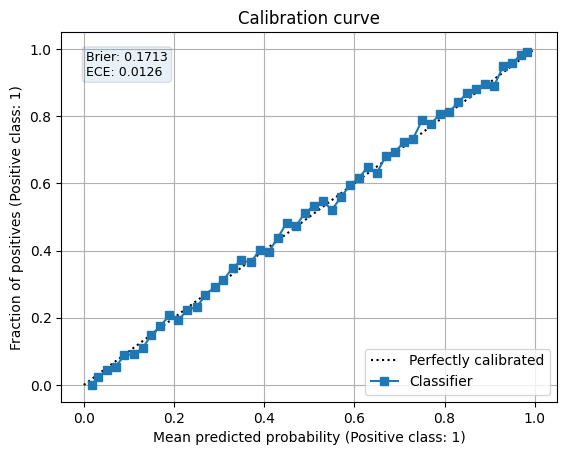

(0.1713306424776801, np.float64(0.01259192963781637))

In [11]:
import pickle
from sklearn.base import clone

with open("../../models/xgb_v1.pkl", "rb") as f:
    model = clone(pickle.load(f))

produce_calibration_curve(model, x_train, x_test, y_train, y_test)

The calibration curve closely resembes the y=x line, meaning the model is already quite accurate in its probability predictions. 

The Brier and ECE scores are also within an acceptable range.